In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.36 s
Wall time: 1.53 s


In [4]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
# user = []
ts = []
# ca = []
tweets = []
# mentions = []
coord = []
# country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        # user.append(line[0])
        ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        coord.append(line[5])
        # country.append(line[6])

CPU times: total: 37.1 s
Wall time: 38.7 s


1. Select countries - keep Ukraine?
2. Isolation forest - identify high-volume days // Bollinger bands
3. Characterize with word clouds / another method

In [90]:
%%time

# Make DF
twt_coord_df_0 = pd.DataFrame(
    list(zip( tweets , coord)) , 
    columns = ['tweet_id' , 'coord']
)

twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['tweet_id']!= "None"].drop_duplicates()
print(f'length is {len(twt_coord_df_0)}')
twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['coord']!= "None"].drop_duplicates()
print(f'length after removing blank coord is {len(twt_coord_df_0)}')

length is 15033548
length after removing blank coord is 701961
CPU times: total: 23.2 s
Wall time: 24.5 s


In [125]:
# Restrict Coords
long_max = 1
long_min = -1
lat_max = 51.75
lat_min = 51.25
twt_coord_df = to_coord(twt_coord_df_0 , ['coord'])

# Constrict to an area over London
twt_coord_df = twt_coord_df[
    (twt_coord_df['coord_long']>=long_min)&(twt_coord_df['coord_long']<=long_max)&
    (twt_coord_df['coord_lat']>=lat_min)&(twt_coord_df['coord_lat']<=lat_max)
]
x_coord = twt_coord_df['coord_long']
y_coord = twt_coord_df['coord_lat']

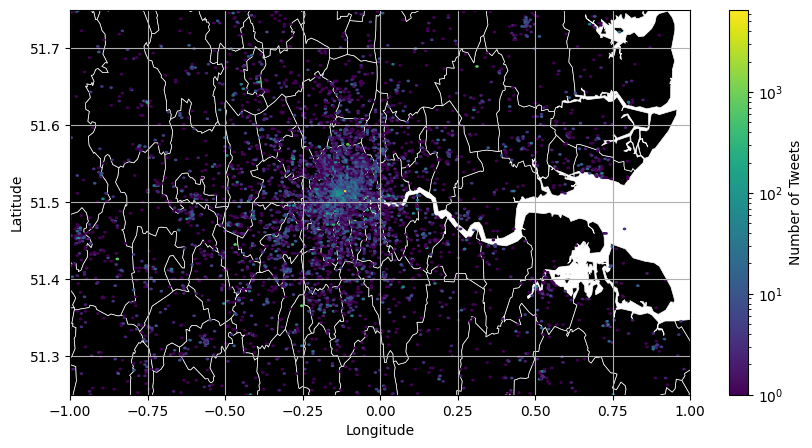

In [141]:
# ex 4

from fastkml import kml
from shapely.geometry import Polygon

with open("C:\\Users\\soura\\Documents\\ECMM443\\17.11.22\\Local_Authority_Districts_(December_2015)_Boundaries.kml" , encoding='utf-8') as my_file:
    doc = my_file.read()
k = kml.KML()
k.from_string(doc)

document = list(k.features())
folder = list(document[0].features())
places = list(folder[0].features())

code_to_name = {}
for p in places:
    poly = p.geometry;
    for d in p.extended_data.elements[0].data:
        if d['name'] == 'lad15cd':
            id_code = d['value']
        if d['name'] == 'lad15nm':
            name = d['value']
    code_to_name[id_code] = poly

patches = []

for c in code_to_name:
    try:
        for pol in code_to_name[c].geoms:
            lons , lats = np.array(pol.exterior.coords.xy)
            patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
            # colours.append(pops[c])
    except AttributeError:
        lons , lats = np.array(code_to_name[c].exterior.coords.xy)
        patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
        # colours.append(pops[c])
# Make subplot
fig , ax = plt.subplots(figsize = (10,5))

# Overlay map
patch_col = PatchCollection(patches , edgecolor = 'white' , lw = 0.5 , facecolor = 'black');
ax.add_collection(patch_col);

# Scatter for tweets
ax1 = ax.hexbin(x_coord , y_coord , gridsize = 300 , bins = 'log' , cmap = "viridis");
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

ax.autoscale();
ax.grid();
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');
plt.xlim(long_min,long_max);
plt.ylim(lat_min,lat_max);

In [32]:
shape_file = os.path.join(os.getcwd() , 'europe-places-shape\\places.shp')

data = {}
pop = {}

with fiona.open(shape_file) as layers:
    for feature in layers:
        name = feature['properties']['name']
        data[name] = shape(feature['geometry'])
        pop[name] = feature['properties']['population']

name = []
lats = []
longs = []
colours = []

for place in data:
    name.append(place)
    longs.append(data[place].x)
    lats.append(data[place].y)
    colours.append(pop[place])
        

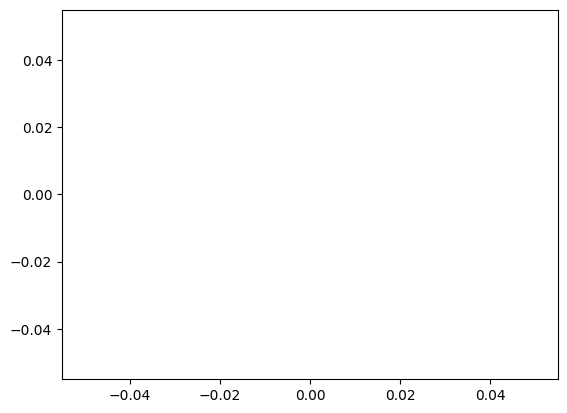

In [ ]:
# Population
place_df_0 = pd.DataFrame(
    list(zip(name, longs, lats, colours)) ,
    columns = ['place', 'longitude', 'latitude', 'population']
)

place_df = place_df_0[place_df_0['population']>0].copy()
place_df['population'] = place_df['population'].apply(lambda x : np.log10(x))

fig , ax = plt.subplots()
ax.scatter(place_df.longitude , place_df.latitude , c = place_df.population , cmap = 'RdYlGn' , s = 0.002);